In [1]:
!pip install tensorflow scikit-learn matplotlib numpy


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train: (35, 28, 28, 1), Val: (15, 28, 28, 1), Test: (10000, 28, 28)
Sample labels: [4 4 0 2 7]


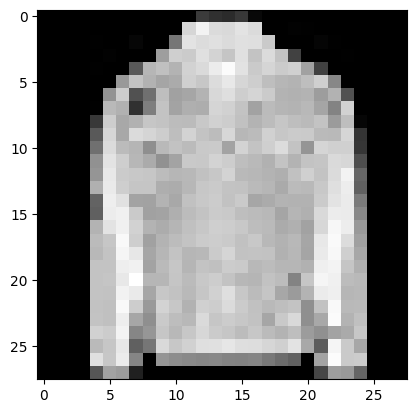

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Load full dataset
(x_full, y_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Take first 50 records as instructed (for train/test combined initially)
x_data = x_full[:50].astype('float32') / 255.0  # Normalize [0,1]
y_data = y_full[:50]
x_data = np.expand_dims(x_data, -1)  # Reshape to (50, 28, 28, 1)

# Split: 70% train (35), 30% val (15); test uses full test set later
X_train, X_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.3, random_state=42, stratify=y_data)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {x_test.shape}")
print("Sample labels:", y_train[:5])
plt.imshow(X_train[0].squeeze(), cmap='gray'); plt.show()


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

def create_cnn_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Test model summary
model = create_cnn_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        54,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
ensemble_models = []
n_models = 5
n_epochs = 3

for i in range(n_models):
    print(f"Training model {i+1}/{n_models}")
    
    # Bootstrap: sample with replacement
    idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_boot, y_boot = X_train[idx], y_train[idx]
    
    # Create & train model
    model = create_cnn_model()
    history = model.fit(X_boot, y_boot, epochs=n_epochs, verbose=0,
                       validation_data=(X_val, y_val))
    ensemble_models.append(model)
    
    # Quick val acc
    _, acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Model {i+1} val acc: {acc:.3f}")

print("Ensemble ready!")


Training model 1/5
Model 1 val acc: 0.400
Training model 2/5
Model 2 val acc: 0.333
Training model 3/5
Model 3 val acc: 0.333
Training model 4/5
Model 4 val acc: 0.267
Training model 5/5
Model 5 val acc: 0.133
Ensemble ready!


In [5]:
from sklearn.metrics import accuracy_score

# Ensemble predict: average probabilities
def ensemble_predict(models, X):
    probs = np.mean([model.predict(X, verbose=0) for model in models], axis=0)
    return np.argmax(probs, axis=1)

# Val & test (normalize/reshape test first)
X_test_norm = x_test[:50].astype('float32') / 255.0  # First 50 test for consistency
X_test_norm = np.expand_dims(X_test_norm, -1)
y_test_small = y_test[:50]

y_val_pred = ensemble_predict(ensemble_models, X_val)
y_test_pred = ensemble_predict(ensemble_models, X_test_norm)

ens_val_acc = accuracy_score(y_val, y_val_pred)
ens_test_acc = accuracy_score(y_test_small, y_test_pred)

print(f"Ensemble Val Acc: {ens_val_acc:.3f}")
print(f"Ensemble Test Acc: {ens_test_acc:.3f}")


Ensemble Val Acc: 0.400
Ensemble Test Acc: 0.240


In [6]:
# Single model on full train
single_model = create_cnn_model()
single_model.fit(X_train, y_train, epochs=3, verbose=1, validation_data=(X_val, y_val))

y_val_single = np.argmax(single_model.predict(X_val, verbose=0), axis=1)
y_test_single = np.argmax(single_model.predict(X_test_norm, verbose=0), axis=1)

single_val_acc = accuracy_score(y_val, y_val_single)
single_test_acc = accuracy_score(y_test_small, y_test_single)

print(f"Single Val Acc: {single_val_acc:.3f}")
print(f"Single Test Acc: {single_test_acc:.3f}")


Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.1074 - loss: 2.2705 - val_accuracy: 0.2000 - val_loss: 2.1409
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2842 - loss: 2.0524 - val_accuracy: 0.2667 - val_loss: 2.0363
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3432 - loss: 1.9199 - val_accuracy: 0.3333 - val_loss: 1.9488
Single Val Acc: 0.333
Single Test Acc: 0.380


In [7]:
print("| Metric | Ensemble | Single | Diff |")
print("|--------|----------|--------|------|")
print(f"| Val Acc | {ens_val_acc:.1%} | {single_val_acc:.1%} | {ens_val_acc-single_val_acc:+.1%} |")
print(f"| Test Acc | {ens_test_acc:.1%} | {single_test_acc:.1%} | {ens_test_acc-single_test_acc:+.1%} |")


| Metric | Ensemble | Single | Diff |
|--------|----------|--------|------|
| Val Acc | 40.0% | 33.3% | +6.7% |
| Test Acc | 24.0% | 38.0% | -14.0% |
